# Models Comparison for TinyML

In [1]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import seaborn as sbs
import sys

warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)
tasks = ["5Labels", "10Labels", "15Labels", "AllLabels"]
# Change this to change subtask
taskIndex = 1

In [3]:
with open('data/X.pkl', 'rb') as f:
    X = pickle.load(f)

with open('data/y.pkl', 'rb') as f:
    y = pickle.load(f)

In [4]:
n_labels = 10
samples = 100
X = X[:n_labels*samples]
y = y[:n_labels*samples]
labels = np.unique(y)

In [5]:
classes = np.unique(y).tolist()
for i in range(len(classes)):
    y = np.where(y==classes[i], i, y)

In [6]:
y = np.array([int(el) for el in y])
print(y)

[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
print(X_test.shape)
print(y_test.shape)


(200, 42)
(200,)


In [8]:
X_test

array([[ 0.17, -0.11,  0.92,  0.15, -0.08,  0.93,  0.16, -0.14,  1.36,
         0.15, -0.28,  0.92,  0.28,  0.01,  0.36,  0.31,  0.11,  0.7 ,
         0.19,  0.29,  1.11,  0.07, -0.1 ,  1.35,  0.1 ,  0.02,  0.65,
         0.18,  0.15,  1.02,  0.13, -0.11,  0.98,  0.15, -0.05,  0.95,
         0.16, -0.01,  0.98,  0.17, -0.  ,  0.97],
       [ 0.1 , -0.03,  0.97,  0.1 , -0.01,  1.02,  0.05, -0.3 ,  1.06,
         0.12, -0.  ,  0.64,  0.12,  0.27,  0.88,  0.08,  0.13,  1.1 ,
         0.06, -0.15,  1.11,  0.13,  0.01,  0.83,  0.16,  0.02,  0.8 ,
         0.12,  0.09,  1.02,  0.07,  0.03,  1.07,  0.04, -0.09,  1.  ,
         0.06, -0.01,  1.  ,  0.06, -0.01,  0.98],
       [ 0.23,  0.03,  0.98,  0.21, -0.  ,  0.92,  0.29,  0.06,  1.18,
         0.23, -0.2 ,  0.95,  0.37,  0.08,  0.6 ,  0.44,  0.21,  0.7 ,
         0.41,  0.28,  1.02,  0.25,  0.16,  1.19,  0.25,  0.07,  0.95,
         0.21,  0.02,  0.96,  0.26,  0.09,  0.95,  0.21,  0.03,  0.97,
         0.23,  0.05,  0.94,  0.21,  0.  ,  0.

In [9]:
y_test

array([1, 0, 6, 5, 0, 2, 9, 2, 4, 5, 0, 0, 8, 0, 9, 3, 8, 5, 3, 9, 2, 6,
       0, 2, 0, 1, 7, 8, 5, 5, 6, 2, 5, 4, 1, 6, 9, 4, 2, 3, 8, 9, 7, 0,
       5, 5, 6, 1, 4, 7, 4, 6, 4, 5, 8, 3, 3, 1, 1, 8, 6, 8, 8, 9, 3, 9,
       9, 1, 9, 7, 6, 8, 1, 7, 8, 4, 3, 7, 7, 7, 3, 7, 8, 4, 5, 9, 8, 4,
       9, 5, 6, 8, 6, 3, 2, 5, 5, 2, 8, 8, 6, 0, 8, 7, 6, 9, 3, 3, 6, 3,
       0, 0, 1, 2, 1, 2, 1, 9, 8, 7, 3, 0, 5, 9, 8, 1, 6, 4, 6, 3, 6, 4,
       7, 5, 7, 2, 3, 2, 3, 8, 5, 0, 3, 0, 2, 4, 4, 0, 1, 4, 7, 1, 1, 0,
       9, 0, 6, 5, 1, 0, 3, 3, 4, 5, 8, 9, 9, 2, 7, 0, 6, 5, 0, 9, 7, 1,
       7, 4, 2, 3, 6, 4, 9, 4, 1, 7, 6, 2, 5, 2, 4, 1, 7, 7, 4, 2, 2, 1,
       9, 2])

## Model Spotting

In [10]:
# Test options and evaluation metric
num_folds = 5
seed = 42
scoring = 'f1_macro'

In [11]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.99, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100, 
                                                           max_features=5, criterion='gini', max_depth=None,
                                                           min_samples_split=4, min_samples_leaf=1)))


In [12]:
# Cross Validation
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,85 0,03
LR - 0,85 0,03
CART - 0,77 0,03
SVC - 0,92 0,01
RF - 0,91 0,02


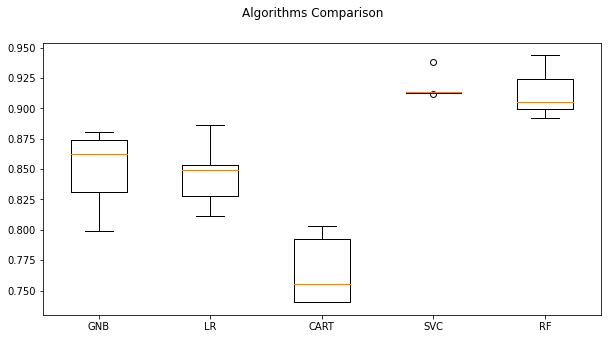

In [13]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi su test

## Valutazione modelli sul Test Set

In [14]:
def classification_report_csv(report, model_name):
    report_data = []
    lines = report.split('\n')
    index = 0
    row = lines[-4].split('    ')
    accuracy = row[-2] if taskIndex > 1 else row[-3]
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = labels[index]
        row['precision'] = float(row_data[2]) 
        row['recall'] = float(row_data[3]) 
        row['f1_score'] = float(row_data[4])
        row['accuracy'] = accuracy
        report_data.append(row)
        index += 1
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(tasks[taskIndex] + "/classificationReports/" +'report' + model_name +  '.csv', index = False)
    
for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    report = classification_report(y_test, pred_test)
    print(report)
    classification_report_csv(report, name)
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.87      1.00      0.93        20
           2       0.95      0.95      0.95        20
           3       0.62      0.80      0.70        20
           4       0.74      1.00      0.85        20
           5       0.92      0.60      0.73        20
           6       0.94      0.80      0.86        20
           7       0.94      0.85      0.89        20
           8       0.83      0.75      0.79        20
           9       0.90      0.90      0.90        20

    accuracy                           0.85       200
   macro avg       0.87      0.86      0.86       200
weighted avg       0.87      0.85      0.86       200

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        20
           1       0.95      0.95      0.95    

# Neural Network

In [15]:
#Hyperparameters of NN
EPOCHS = 500 
BATCH_SIZE = 7
learn_rate = 0.001
nodes = 256
def getNetwork():
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dropout(0.25))    
    model.add(layers.Dense(nodes, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    opt = Adam(learning_rate=learn_rate)
    # SGB
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

## Cross Validation NN

In [16]:
num_folds = 5

kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 42)                1806      
_________________________________________________________________
dropout (Dropout)            (None, 42)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               11008     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 15,384
Trainable params: 15,384
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
92/92 [==============================] - 0s 535us/step - loss: 2.2576 - accuracy: 0.1609
Epoch 2/500
92

92/92 [==============================] - 0s 513us/step - loss: 0.2267 - accuracy: 0.9141
Epoch 72/500
92/92 [==============================] - 0s 508us/step - loss: 0.1976 - accuracy: 0.9187
Epoch 73/500
92/92 [==============================] - 0s 518us/step - loss: 0.1844 - accuracy: 0.9328
Epoch 74/500
92/92 [==============================] - 0s 529us/step - loss: 0.1916 - accuracy: 0.9328
Epoch 75/500
92/92 [==============================] - 0s 509us/step - loss: 0.1950 - accuracy: 0.9344
Epoch 76/500
92/92 [==============================] - 0s 531us/step - loss: 0.1779 - accuracy: 0.9281
Epoch 77/500
92/92 [==============================] - 0s 510us/step - loss: 0.1759 - accuracy: 0.9359
Epoch 78/500
92/92 [==============================] - 0s 507us/step - loss: 0.2219 - accuracy: 0.9312
Epoch 79/500
92/92 [==============================] - 0s 529us/step - loss: 0.1934 - accuracy: 0.9234
Epoch 80/500
92/92 [==============================] - 0s 501us/step - loss: 0.1776 - accuracy: 

92/92 [==============================] - 0s 553us/step - loss: 0.1196 - accuracy: 0.9594
Epoch 151/500
92/92 [==============================] - 0s 518us/step - loss: 0.0951 - accuracy: 0.9656
Epoch 152/500
92/92 [==============================] - 0s 539us/step - loss: 0.1193 - accuracy: 0.9547
Epoch 153/500
92/92 [==============================] - 0s 544us/step - loss: 0.1121 - accuracy: 0.9625
Epoch 154/500
92/92 [==============================] - 0s 527us/step - loss: 0.1057 - accuracy: 0.9625
Epoch 155/500
92/92 [==============================] - 0s 534us/step - loss: 0.0992 - accuracy: 0.9688
Epoch 156/500
92/92 [==============================] - 0s 540us/step - loss: 0.1172 - accuracy: 0.9563
Epoch 157/500
92/92 [==============================] - 0s 533us/step - loss: 0.0972 - accuracy: 0.9641
Epoch 158/500
92/92 [==============================] - 0s 530us/step - loss: 0.0961 - accuracy: 0.9703
Epoch 159/500
92/92 [==============================] - 0s 508us/step - loss: 0.1298 - a

92/92 [==============================] - 0s 529us/step - loss: 0.0813 - accuracy: 0.9656
Epoch 230/500
92/92 [==============================] - 0s 531us/step - loss: 0.0669 - accuracy: 0.9672
Epoch 231/500
92/92 [==============================] - 0s 505us/step - loss: 0.0631 - accuracy: 0.9750
Epoch 232/500
92/92 [==============================] - 0s 521us/step - loss: 0.0676 - accuracy: 0.9734
Epoch 233/500
92/92 [==============================] - 0s 508us/step - loss: 0.0891 - accuracy: 0.9688
Epoch 234/500
92/92 [==============================] - 0s 516us/step - loss: 0.0727 - accuracy: 0.9734
Epoch 235/500
92/92 [==============================] - 0s 524us/step - loss: 0.0487 - accuracy: 0.9797
Epoch 236/500
92/92 [==============================] - 0s 509us/step - loss: 0.0796 - accuracy: 0.9625
Epoch 237/500
92/92 [==============================] - 0s 523us/step - loss: 0.0788 - accuracy: 0.9688
Epoch 238/500
92/92 [==============================] - 0s 501us/step - loss: 0.0822 - a

92/92 [==============================] - 0s 518us/step - loss: 0.0580 - accuracy: 0.9766
Epoch 309/500
92/92 [==============================] - 0s 520us/step - loss: 0.0800 - accuracy: 0.9703
Epoch 310/500
92/92 [==============================] - 0s 518us/step - loss: 0.0703 - accuracy: 0.9797
Epoch 311/500
92/92 [==============================] - 0s 518us/step - loss: 0.0532 - accuracy: 0.9812
Epoch 312/500
92/92 [==============================] - 0s 515us/step - loss: 0.0531 - accuracy: 0.9797
Epoch 313/500
92/92 [==============================] - 0s 538us/step - loss: 0.0883 - accuracy: 0.9688
Epoch 314/500
92/92 [==============================] - 0s 511us/step - loss: 0.0747 - accuracy: 0.9734
Epoch 315/500
92/92 [==============================] - 0s 518us/step - loss: 0.0669 - accuracy: 0.9797
Epoch 316/500
92/92 [==============================] - 0s 517us/step - loss: 0.0662 - accuracy: 0.9703
Epoch 317/500
92/92 [==============================] - 0s 519us/step - loss: 0.0469 - a

92/92 [==============================] - 0s 506us/step - loss: 0.0388 - accuracy: 0.9875
Epoch 388/500
92/92 [==============================] - 0s 521us/step - loss: 0.0526 - accuracy: 0.9828
Epoch 389/500
92/92 [==============================] - 0s 500us/step - loss: 0.0668 - accuracy: 0.9734
Epoch 390/500
92/92 [==============================] - 0s 508us/step - loss: 0.0349 - accuracy: 0.9922
Epoch 391/500
92/92 [==============================] - 0s 533us/step - loss: 0.0694 - accuracy: 0.9734
Epoch 392/500
92/92 [==============================] - 0s 499us/step - loss: 0.0643 - accuracy: 0.9688
Epoch 393/500
92/92 [==============================] - 0s 514us/step - loss: 0.0557 - accuracy: 0.9781
Epoch 394/500
92/92 [==============================] - 0s 511us/step - loss: 0.0801 - accuracy: 0.9688
Epoch 395/500
92/92 [==============================] - 0s 540us/step - loss: 0.0594 - accuracy: 0.9797
Epoch 396/500
92/92 [==============================] - 0s 523us/step - loss: 0.0609 - a

92/92 [==============================] - 0s 574us/step - loss: 0.0646 - accuracy: 0.9844
Epoch 467/500
92/92 [==============================] - 0s 537us/step - loss: 0.0289 - accuracy: 0.9922
Epoch 468/500
92/92 [==============================] - 0s 531us/step - loss: 0.0304 - accuracy: 0.9922
Epoch 469/500
92/92 [==============================] - 0s 530us/step - loss: 0.1137 - accuracy: 0.9672
Epoch 470/500
92/92 [==============================] - 0s 525us/step - loss: 0.0629 - accuracy: 0.9812
Epoch 471/500
92/92 [==============================] - 0s 536us/step - loss: 0.0741 - accuracy: 0.9766
Epoch 472/500
92/92 [==============================] - 0s 554us/step - loss: 0.0735 - accuracy: 0.9766
Epoch 473/500
92/92 [==============================] - 0s 516us/step - loss: 0.0557 - accuracy: 0.9766
Epoch 474/500
92/92 [==============================] - 0s 531us/step - loss: 0.0684 - accuracy: 0.9781
Epoch 475/500
92/92 [==============================] - 0s 530us/step - loss: 0.0600 - a

92/92 [==============================] - 0s 522us/step - loss: 0.3709 - accuracy: 0.8656
Epoch 37/500
92/92 [==============================] - 0s 520us/step - loss: 0.3447 - accuracy: 0.8687
Epoch 38/500
92/92 [==============================] - 0s 522us/step - loss: 0.3651 - accuracy: 0.8703
Epoch 39/500
92/92 [==============================] - 0s 544us/step - loss: 0.3532 - accuracy: 0.8719
Epoch 40/500
92/92 [==============================] - 0s 504us/step - loss: 0.3413 - accuracy: 0.8719
Epoch 41/500
92/92 [==============================] - 0s 513us/step - loss: 0.3578 - accuracy: 0.8672
Epoch 42/500
92/92 [==============================] - 0s 507us/step - loss: 0.3264 - accuracy: 0.8656
Epoch 43/500
92/92 [==============================] - 0s 519us/step - loss: 0.3157 - accuracy: 0.8781
Epoch 44/500
92/92 [==============================] - 0s 540us/step - loss: 0.3342 - accuracy: 0.8750
Epoch 45/500
92/92 [==============================] - 0s 505us/step - loss: 0.3061 - accuracy: 

92/92 [==============================] - 0s 540us/step - loss: 0.1727 - accuracy: 0.9359
Epoch 117/500
92/92 [==============================] - 0s 521us/step - loss: 0.1465 - accuracy: 0.9359
Epoch 118/500
92/92 [==============================] - 0s 525us/step - loss: 0.1691 - accuracy: 0.9438
Epoch 119/500
92/92 [==============================] - 0s 527us/step - loss: 0.1578 - accuracy: 0.9438
Epoch 120/500
92/92 [==============================] - 0s 511us/step - loss: 0.1169 - accuracy: 0.9563
Epoch 121/500
92/92 [==============================] - 0s 507us/step - loss: 0.1149 - accuracy: 0.9531
Epoch 122/500
92/92 [==============================] - 0s 505us/step - loss: 0.1444 - accuracy: 0.9469
Epoch 123/500
92/92 [==============================] - 0s 530us/step - loss: 0.1254 - accuracy: 0.9531
Epoch 124/500
92/92 [==============================] - 0s 494us/step - loss: 0.1178 - accuracy: 0.9625
Epoch 125/500
92/92 [==============================] - 0s 536us/step - loss: 0.1467 - a

92/92 [==============================] - 0s 523us/step - loss: 0.0995 - accuracy: 0.9484
Epoch 196/500
92/92 [==============================] - 0s 509us/step - loss: 0.1252 - accuracy: 0.9578
Epoch 197/500
92/92 [==============================] - 0s 529us/step - loss: 0.0967 - accuracy: 0.9625
Epoch 198/500
92/92 [==============================] - 0s 555us/step - loss: 0.0908 - accuracy: 0.9688
Epoch 199/500
92/92 [==============================] - 0s 576us/step - loss: 0.1054 - accuracy: 0.9563
Epoch 200/500
92/92 [==============================] - 0s 560us/step - loss: 0.1169 - accuracy: 0.9609
Epoch 201/500
92/92 [==============================] - 0s 536us/step - loss: 0.1102 - accuracy: 0.9547
Epoch 202/500
92/92 [==============================] - 0s 527us/step - loss: 0.0802 - accuracy: 0.9672
Epoch 203/500
92/92 [==============================] - 0s 513us/step - loss: 0.0768 - accuracy: 0.9750
Epoch 204/500
92/92 [==============================] - 0s 504us/step - loss: 0.0806 - a

92/92 [==============================] - 0s 537us/step - loss: 0.0771 - accuracy: 0.9750
Epoch 275/500
92/92 [==============================] - 0s 540us/step - loss: 0.0847 - accuracy: 0.9734
Epoch 276/500
92/92 [==============================] - 0s 522us/step - loss: 0.0868 - accuracy: 0.9766
Epoch 277/500
92/92 [==============================] - 0s 733us/step - loss: 0.0721 - accuracy: 0.9719
Epoch 278/500
92/92 [==============================] - 0s 518us/step - loss: 0.1006 - accuracy: 0.9625
Epoch 279/500
92/92 [==============================] - 0s 511us/step - loss: 0.0998 - accuracy: 0.9641
Epoch 280/500
92/92 [==============================] - 0s 518us/step - loss: 0.0894 - accuracy: 0.9672
Epoch 281/500
92/92 [==============================] - 0s 527us/step - loss: 0.0993 - accuracy: 0.9563
Epoch 282/500
92/92 [==============================] - 0s 564us/step - loss: 0.1000 - accuracy: 0.9641
Epoch 283/500
92/92 [==============================] - 0s 563us/step - loss: 0.0685 - a

92/92 [==============================] - 0s 537us/step - loss: 0.0839 - accuracy: 0.9781
Epoch 354/500
92/92 [==============================] - 0s 477us/step - loss: 0.0594 - accuracy: 0.9750
Epoch 355/500
92/92 [==============================] - 0s 472us/step - loss: 0.0721 - accuracy: 0.9734
Epoch 356/500
92/92 [==============================] - 0s 525us/step - loss: 0.0633 - accuracy: 0.9781
Epoch 357/500
92/92 [==============================] - 0s 527us/step - loss: 0.0689 - accuracy: 0.9781
Epoch 358/500
92/92 [==============================] - 0s 488us/step - loss: 0.0477 - accuracy: 0.9844
Epoch 359/500
92/92 [==============================] - 0s 467us/step - loss: 0.0502 - accuracy: 0.9844
Epoch 360/500
92/92 [==============================] - 0s 514us/step - loss: 0.0637 - accuracy: 0.9766
Epoch 361/500
92/92 [==============================] - 0s 581us/step - loss: 0.0666 - accuracy: 0.9781
Epoch 362/500
92/92 [==============================] - 0s 552us/step - loss: 0.0733 - a

92/92 [==============================] - 0s 599us/step - loss: 0.0751 - accuracy: 0.9750
Epoch 433/500
92/92 [==============================] - 0s 648us/step - loss: 0.1179 - accuracy: 0.9609
Epoch 434/500
92/92 [==============================] - 0s 593us/step - loss: 0.0361 - accuracy: 0.9906
Epoch 435/500
92/92 [==============================] - 0s 560us/step - loss: 0.0582 - accuracy: 0.9781
Epoch 436/500
92/92 [==============================] - 0s 616us/step - loss: 0.0301 - accuracy: 0.9891
Epoch 437/500
92/92 [==============================] - 0s 502us/step - loss: 0.0560 - accuracy: 0.9797
Epoch 438/500
92/92 [==============================] - 0s 504us/step - loss: 0.0619 - accuracy: 0.9766
Epoch 439/500
92/92 [==============================] - 0s 560us/step - loss: 0.0759 - accuracy: 0.9734
Epoch 440/500
92/92 [==============================] - 0s 568us/step - loss: 0.0863 - accuracy: 0.9750
Epoch 441/500
92/92 [==============================] - 0s 485us/step - loss: 0.0510 - a

92/92 [==============================] - 0s 504us/step - loss: 2.2514 - accuracy: 0.1719
Epoch 2/500
92/92 [==============================] - 0s 477us/step - loss: 1.8915 - accuracy: 0.3578
Epoch 3/500
92/92 [==============================] - 0s 530us/step - loss: 1.4688 - accuracy: 0.5109
Epoch 4/500
92/92 [==============================] - 0s 576us/step - loss: 1.2217 - accuracy: 0.5875
Epoch 5/500
92/92 [==============================] - 0s 568us/step - loss: 1.0977 - accuracy: 0.6313
Epoch 6/500
92/92 [==============================] - 0s 553us/step - loss: 1.0114 - accuracy: 0.6406
Epoch 7/500
92/92 [==============================] - 0s 534us/step - loss: 0.9169 - accuracy: 0.6891
Epoch 8/500
92/92 [==============================] - 0s 535us/step - loss: 0.8498 - accuracy: 0.7234
Epoch 9/500
92/92 [==============================] - 0s 569us/step - loss: 0.7729 - accuracy: 0.7063
Epoch 10/500
92/92 [==============================] - 0s 551us/step - loss: 0.7557 - accuracy: 0.7234
E

92/92 [==============================] - 0s 463us/step - loss: 0.1757 - accuracy: 0.9391
Epoch 82/500
92/92 [==============================] - 0s 463us/step - loss: 0.2161 - accuracy: 0.9281
Epoch 83/500
92/92 [==============================] - 0s 478us/step - loss: 0.2019 - accuracy: 0.9109
Epoch 84/500
92/92 [==============================] - 0s 464us/step - loss: 0.1820 - accuracy: 0.9375
Epoch 85/500
92/92 [==============================] - 0s 475us/step - loss: 0.2023 - accuracy: 0.9297
Epoch 86/500
92/92 [==============================] - 0s 462us/step - loss: 0.1938 - accuracy: 0.9250
Epoch 87/500
92/92 [==============================] - 0s 475us/step - loss: 0.1780 - accuracy: 0.9297
Epoch 88/500
92/92 [==============================] - 0s 476us/step - loss: 0.1558 - accuracy: 0.9453
Epoch 89/500
92/92 [==============================] - 0s 486us/step - loss: 0.1666 - accuracy: 0.9359
Epoch 90/500
92/92 [==============================] - 0s 471us/step - loss: 0.1798 - accuracy: 

92/92 [==============================] - 0s 534us/step - loss: 0.1397 - accuracy: 0.9484
Epoch 161/500
92/92 [==============================] - 0s 525us/step - loss: 0.0939 - accuracy: 0.9672
Epoch 162/500
92/92 [==============================] - 0s 487us/step - loss: 0.1213 - accuracy: 0.9703
Epoch 163/500
92/92 [==============================] - 0s 490us/step - loss: 0.0929 - accuracy: 0.9703
Epoch 164/500
92/92 [==============================] - 0s 498us/step - loss: 0.0873 - accuracy: 0.9672
Epoch 165/500
92/92 [==============================] - 0s 496us/step - loss: 0.0930 - accuracy: 0.9656
Epoch 166/500
92/92 [==============================] - 0s 522us/step - loss: 0.1199 - accuracy: 0.9547
Epoch 167/500
92/92 [==============================] - 0s 512us/step - loss: 0.1003 - accuracy: 0.9703
Epoch 168/500
92/92 [==============================] - 0s 508us/step - loss: 0.0948 - accuracy: 0.9734
Epoch 169/500
92/92 [==============================] - 0s 519us/step - loss: 0.0953 - a

92/92 [==============================] - 0s 466us/step - loss: 0.1018 - accuracy: 0.9656
Epoch 240/500
92/92 [==============================] - 0s 462us/step - loss: 0.0875 - accuracy: 0.9641
Epoch 241/500
92/92 [==============================] - 0s 471us/step - loss: 0.0613 - accuracy: 0.9781
Epoch 242/500
92/92 [==============================] - 0s 457us/step - loss: 0.0746 - accuracy: 0.9688
Epoch 243/500
92/92 [==============================] - 0s 509us/step - loss: 0.0765 - accuracy: 0.9672
Epoch 244/500
92/92 [==============================] - 0s 490us/step - loss: 0.0410 - accuracy: 0.9844
Epoch 245/500
92/92 [==============================] - 0s 468us/step - loss: 0.0664 - accuracy: 0.9828
Epoch 246/500
92/92 [==============================] - 0s 480us/step - loss: 0.0728 - accuracy: 0.9766
Epoch 247/500
92/92 [==============================] - 0s 513us/step - loss: 0.0865 - accuracy: 0.9672
Epoch 248/500
92/92 [==============================] - 0s 453us/step - loss: 0.0792 - a

92/92 [==============================] - 0s 499us/step - loss: 0.0518 - accuracy: 0.9766
Epoch 319/500
92/92 [==============================] - 0s 476us/step - loss: 0.0578 - accuracy: 0.9797
Epoch 320/500
92/92 [==============================] - 0s 468us/step - loss: 0.0784 - accuracy: 0.9719
Epoch 321/500
92/92 [==============================] - 0s 465us/step - loss: 0.1014 - accuracy: 0.9609
Epoch 322/500
92/92 [==============================] - 0s 485us/step - loss: 0.0784 - accuracy: 0.9625
Epoch 323/500
92/92 [==============================] - 0s 539us/step - loss: 0.0583 - accuracy: 0.9781
Epoch 324/500
92/92 [==============================] - 0s 533us/step - loss: 0.0529 - accuracy: 0.9828
Epoch 325/500
92/92 [==============================] - 0s 534us/step - loss: 0.0624 - accuracy: 0.9797
Epoch 326/500
92/92 [==============================] - 0s 565us/step - loss: 0.0810 - accuracy: 0.9688
Epoch 327/500
92/92 [==============================] - 0s 562us/step - loss: 0.0659 - a

92/92 [==============================] - 0s 502us/step - loss: 0.0580 - accuracy: 0.9812
Epoch 398/500
92/92 [==============================] - 0s 488us/step - loss: 0.0618 - accuracy: 0.9750
Epoch 399/500
92/92 [==============================] - 0s 471us/step - loss: 0.0737 - accuracy: 0.9703
Epoch 400/500
92/92 [==============================] - 0s 487us/step - loss: 0.0984 - accuracy: 0.9641
Epoch 401/500
92/92 [==============================] - 0s 503us/step - loss: 0.0611 - accuracy: 0.9750
Epoch 402/500
92/92 [==============================] - 0s 508us/step - loss: 0.0531 - accuracy: 0.9828
Epoch 403/500
92/92 [==============================] - 0s 522us/step - loss: 0.0546 - accuracy: 0.9844
Epoch 404/500
92/92 [==============================] - 0s 499us/step - loss: 0.0340 - accuracy: 0.9875
Epoch 405/500
92/92 [==============================] - 0s 482us/step - loss: 0.0469 - accuracy: 0.9844
Epoch 406/500
92/92 [==============================] - 0s 492us/step - loss: 0.0299 - a

92/92 [==============================] - 0s 477us/step - loss: 0.0415 - accuracy: 0.9859
Epoch 477/500
92/92 [==============================] - 0s 484us/step - loss: 0.0838 - accuracy: 0.9672
Epoch 478/500
92/92 [==============================] - 0s 481us/step - loss: 0.0403 - accuracy: 0.9859
Epoch 479/500
92/92 [==============================] - 0s 463us/step - loss: 0.0603 - accuracy: 0.9734
Epoch 480/500
92/92 [==============================] - 0s 463us/step - loss: 0.0553 - accuracy: 0.9812
Epoch 481/500
92/92 [==============================] - 0s 473us/step - loss: 0.0649 - accuracy: 0.9781
Epoch 482/500
92/92 [==============================] - 0s 520us/step - loss: 0.0818 - accuracy: 0.9719
Epoch 483/500
92/92 [==============================] - 0s 499us/step - loss: 0.0671 - accuracy: 0.9828
Epoch 484/500
92/92 [==============================] - 0s 480us/step - loss: 0.0605 - accuracy: 0.9828
Epoch 485/500
92/92 [==============================] - 0s 482us/step - loss: 0.0240 - a

92/92 [==============================] - 0s 463us/step - loss: 0.2755 - accuracy: 0.9062
Epoch 47/500
92/92 [==============================] - 0s 462us/step - loss: 0.2711 - accuracy: 0.8953
Epoch 48/500
92/92 [==============================] - 0s 462us/step - loss: 0.3027 - accuracy: 0.8938
Epoch 49/500
92/92 [==============================] - 0s 462us/step - loss: 0.2654 - accuracy: 0.9141
Epoch 50/500
92/92 [==============================] - 0s 453us/step - loss: 0.2574 - accuracy: 0.9000
Epoch 51/500
92/92 [==============================] - 0s 465us/step - loss: 0.2977 - accuracy: 0.9016
Epoch 52/500
92/92 [==============================] - 0s 485us/step - loss: 0.2672 - accuracy: 0.9016
Epoch 53/500
92/92 [==============================] - 0s 512us/step - loss: 0.2297 - accuracy: 0.9219
Epoch 54/500
92/92 [==============================] - 0s 474us/step - loss: 0.2709 - accuracy: 0.8922
Epoch 55/500
92/92 [==============================] - 0s 493us/step - loss: 0.2603 - accuracy: 

92/92 [==============================] - 0s 511us/step - loss: 0.1383 - accuracy: 0.9500
Epoch 127/500
92/92 [==============================] - 0s 571us/step - loss: 0.0956 - accuracy: 0.9703
Epoch 128/500
92/92 [==============================] - 0s 500us/step - loss: 0.1089 - accuracy: 0.9625
Epoch 129/500
92/92 [==============================] - 0s 501us/step - loss: 0.0884 - accuracy: 0.9656
Epoch 130/500
92/92 [==============================] - 0s 544us/step - loss: 0.1024 - accuracy: 0.9641
Epoch 131/500
92/92 [==============================] - 0s 474us/step - loss: 0.1076 - accuracy: 0.9641
Epoch 132/500
92/92 [==============================] - 0s 472us/step - loss: 0.1185 - accuracy: 0.9656
Epoch 133/500
92/92 [==============================] - 0s 462us/step - loss: 0.1158 - accuracy: 0.9594
Epoch 134/500
92/92 [==============================] - 0s 453us/step - loss: 0.1176 - accuracy: 0.9656
Epoch 135/500
92/92 [==============================] - 0s 455us/step - loss: 0.0965 - a

92/92 [==============================] - 0s 565us/step - loss: 0.0823 - accuracy: 0.9750
Epoch 206/500
92/92 [==============================] - 0s 581us/step - loss: 0.0654 - accuracy: 0.9719
Epoch 207/500
92/92 [==============================] - 0s 570us/step - loss: 0.0657 - accuracy: 0.9719
Epoch 208/500
92/92 [==============================] - 0s 582us/step - loss: 0.1023 - accuracy: 0.9641
Epoch 209/500
92/92 [==============================] - 0s 535us/step - loss: 0.0685 - accuracy: 0.9641
Epoch 210/500
92/92 [==============================] - 0s 530us/step - loss: 0.0546 - accuracy: 0.9812
Epoch 211/500
92/92 [==============================] - 0s 512us/step - loss: 0.0889 - accuracy: 0.9688
Epoch 212/500
92/92 [==============================] - 0s 523us/step - loss: 0.0717 - accuracy: 0.9703
Epoch 213/500
92/92 [==============================] - 0s 560us/step - loss: 0.0886 - accuracy: 0.9656
Epoch 214/500
92/92 [==============================] - 0s 563us/step - loss: 0.0761 - a

92/92 [==============================] - 0s 563us/step - loss: 0.0777 - accuracy: 0.9703
Epoch 285/500
92/92 [==============================] - 0s 533us/step - loss: 0.0546 - accuracy: 0.9781
Epoch 286/500
92/92 [==============================] - 0s 529us/step - loss: 0.0795 - accuracy: 0.9688
Epoch 287/500
92/92 [==============================] - 0s 523us/step - loss: 0.0813 - accuracy: 0.9734
Epoch 288/500
92/92 [==============================] - 0s 512us/step - loss: 0.0666 - accuracy: 0.9734
Epoch 289/500
92/92 [==============================] - 0s 505us/step - loss: 0.0749 - accuracy: 0.9672
Epoch 290/500
92/92 [==============================] - 0s 531us/step - loss: 0.0822 - accuracy: 0.9672
Epoch 291/500
92/92 [==============================] - 0s 588us/step - loss: 0.1057 - accuracy: 0.9703
Epoch 292/500
92/92 [==============================] - 0s 543us/step - loss: 0.0858 - accuracy: 0.9703
Epoch 293/500
92/92 [==============================] - 0s 524us/step - loss: 0.0786 - a

92/92 [==============================] - 0s 516us/step - loss: 0.0456 - accuracy: 0.9844
Epoch 364/500
92/92 [==============================] - 0s 517us/step - loss: 0.0809 - accuracy: 0.9750
Epoch 365/500
92/92 [==============================] - 0s 516us/step - loss: 0.0562 - accuracy: 0.9781
Epoch 366/500
92/92 [==============================] - 0s 512us/step - loss: 0.0501 - accuracy: 0.9844
Epoch 367/500
92/92 [==============================] - 0s 511us/step - loss: 0.0777 - accuracy: 0.9734
Epoch 368/500
92/92 [==============================] - 0s 506us/step - loss: 0.0442 - accuracy: 0.9812
Epoch 369/500
92/92 [==============================] - 0s 530us/step - loss: 0.0541 - accuracy: 0.9734
Epoch 370/500
92/92 [==============================] - 0s 524us/step - loss: 0.0686 - accuracy: 0.9672
Epoch 371/500
92/92 [==============================] - 0s 526us/step - loss: 0.0838 - accuracy: 0.9719
Epoch 372/500
92/92 [==============================] - 0s 513us/step - loss: 0.0556 - a

92/92 [==============================] - 0s 513us/step - loss: 0.0794 - accuracy: 0.9734
Epoch 443/500
92/92 [==============================] - 0s 515us/step - loss: 0.0372 - accuracy: 0.9891
Epoch 444/500
92/92 [==============================] - 0s 526us/step - loss: 0.0280 - accuracy: 0.9937
Epoch 445/500
92/92 [==============================] - 0s 503us/step - loss: 0.0395 - accuracy: 0.9875
Epoch 446/500
92/92 [==============================] - 0s 511us/step - loss: 0.0507 - accuracy: 0.9797
Epoch 447/500
92/92 [==============================] - 0s 540us/step - loss: 0.0563 - accuracy: 0.9812
Epoch 448/500
92/92 [==============================] - 0s 564us/step - loss: 0.0726 - accuracy: 0.9734
Epoch 449/500
92/92 [==============================] - 0s 539us/step - loss: 0.0481 - accuracy: 0.9812
Epoch 450/500
92/92 [==============================] - 0s 497us/step - loss: 0.0562 - accuracy: 0.9844
Epoch 451/500
92/92 [==============================] - 0s 511us/step - loss: 0.0538 - a

Epoch 12/500
92/92 [==============================] - 0s 517us/step - loss: 0.7143 - accuracy: 0.7422
Epoch 13/500
92/92 [==============================] - 0s 538us/step - loss: 0.7021 - accuracy: 0.7531
Epoch 14/500
92/92 [==============================] - 0s 531us/step - loss: 0.6825 - accuracy: 0.7422
Epoch 15/500
92/92 [==============================] - 0s 504us/step - loss: 0.6649 - accuracy: 0.7656
Epoch 16/500
92/92 [==============================] - 0s 520us/step - loss: 0.6430 - accuracy: 0.7734
Epoch 17/500
92/92 [==============================] - 0s 523us/step - loss: 0.6254 - accuracy: 0.7797
Epoch 18/500
92/92 [==============================] - 0s 527us/step - loss: 0.5696 - accuracy: 0.7844
Epoch 19/500
92/92 [==============================] - 0s 529us/step - loss: 0.5592 - accuracy: 0.8000
Epoch 20/500
92/92 [==============================] - 0s 497us/step - loss: 0.5668 - accuracy: 0.7766
Epoch 21/500
92/92 [==============================] - 0s 519us/step - loss: 0.5481

92/92 [==============================] - 0s 507us/step - loss: 0.1656 - accuracy: 0.9406
Epoch 93/500
92/92 [==============================] - 0s 530us/step - loss: 0.1407 - accuracy: 0.9500
Epoch 94/500
92/92 [==============================] - 0s 506us/step - loss: 0.1736 - accuracy: 0.9328
Epoch 95/500
92/92 [==============================] - 0s 499us/step - loss: 0.1807 - accuracy: 0.9344
Epoch 96/500
92/92 [==============================] - 0s 523us/step - loss: 0.1746 - accuracy: 0.9391
Epoch 97/500
92/92 [==============================] - 0s 514us/step - loss: 0.1748 - accuracy: 0.9359
Epoch 98/500
92/92 [==============================] - 0s 506us/step - loss: 0.1239 - accuracy: 0.9531
Epoch 99/500
92/92 [==============================] - 0s 526us/step - loss: 0.1668 - accuracy: 0.9266
Epoch 100/500
92/92 [==============================] - 0s 493us/step - loss: 0.1565 - accuracy: 0.9484
Epoch 101/500
92/92 [==============================] - 0s 516us/step - loss: 0.1665 - accuracy

92/92 [==============================] - 0s 531us/step - loss: 0.0931 - accuracy: 0.9656
Epoch 172/500
92/92 [==============================] - 0s 501us/step - loss: 0.1165 - accuracy: 0.9531
Epoch 173/500
92/92 [==============================] - 0s 577us/step - loss: 0.1007 - accuracy: 0.9625
Epoch 174/500
92/92 [==============================] - 0s 511us/step - loss: 0.0935 - accuracy: 0.9703
Epoch 175/500
92/92 [==============================] - 0s 502us/step - loss: 0.1262 - accuracy: 0.9500
Epoch 176/500
92/92 [==============================] - 0s 504us/step - loss: 0.0855 - accuracy: 0.9672
Epoch 177/500
92/92 [==============================] - 0s 523us/step - loss: 0.1214 - accuracy: 0.9578
Epoch 178/500
92/92 [==============================] - 0s 516us/step - loss: 0.1296 - accuracy: 0.9563
Epoch 179/500
92/92 [==============================] - 0s 517us/step - loss: 0.1278 - accuracy: 0.9484
Epoch 180/500
92/92 [==============================] - 0s 526us/step - loss: 0.1184 - a

92/92 [==============================] - 0s 502us/step - loss: 0.0653 - accuracy: 0.9812
Epoch 251/500
92/92 [==============================] - 0s 494us/step - loss: 0.0937 - accuracy: 0.9625
Epoch 252/500
92/92 [==============================] - 0s 491us/step - loss: 0.0780 - accuracy: 0.9656
Epoch 253/500
92/92 [==============================] - 0s 520us/step - loss: 0.0648 - accuracy: 0.9797
Epoch 254/500
92/92 [==============================] - 0s 527us/step - loss: 0.0935 - accuracy: 0.9703
Epoch 255/500
92/92 [==============================] - 0s 515us/step - loss: 0.0758 - accuracy: 0.9766
Epoch 256/500
92/92 [==============================] - 0s 529us/step - loss: 0.0649 - accuracy: 0.9734
Epoch 257/500
92/92 [==============================] - 0s 497us/step - loss: 0.0787 - accuracy: 0.9719
Epoch 258/500
92/92 [==============================] - 0s 539us/step - loss: 0.0801 - accuracy: 0.9703
Epoch 259/500
92/92 [==============================] - 0s 521us/step - loss: 0.0688 - a

92/92 [==============================] - 0s 526us/step - loss: 0.0788 - accuracy: 0.9703
Epoch 330/500
92/92 [==============================] - 0s 526us/step - loss: 0.0763 - accuracy: 0.9797
Epoch 331/500
92/92 [==============================] - 0s 528us/step - loss: 0.0617 - accuracy: 0.9734
Epoch 332/500
92/92 [==============================] - 0s 506us/step - loss: 0.0776 - accuracy: 0.9781
Epoch 333/500
92/92 [==============================] - 0s 523us/step - loss: 0.0519 - accuracy: 0.9828
Epoch 334/500
92/92 [==============================] - 0s 515us/step - loss: 0.0449 - accuracy: 0.9828
Epoch 335/500
92/92 [==============================] - 0s 539us/step - loss: 0.0677 - accuracy: 0.9734
Epoch 336/500
92/92 [==============================] - 0s 498us/step - loss: 0.0794 - accuracy: 0.9703
Epoch 337/500
92/92 [==============================] - 0s 519us/step - loss: 0.0753 - accuracy: 0.9766
Epoch 338/500
92/92 [==============================] - 0s 534us/step - loss: 0.0391 - a

92/92 [==============================] - 0s 509us/step - loss: 0.0893 - accuracy: 0.9656
Epoch 409/500
92/92 [==============================] - 0s 497us/step - loss: 0.0962 - accuracy: 0.9719
Epoch 410/500
92/92 [==============================] - 0s 527us/step - loss: 0.0485 - accuracy: 0.9797
Epoch 411/500
92/92 [==============================] - 0s 516us/step - loss: 0.0422 - accuracy: 0.9844
Epoch 412/500
92/92 [==============================] - 0s 533us/step - loss: 0.0360 - accuracy: 0.9859
Epoch 413/500
92/92 [==============================] - 0s 530us/step - loss: 0.0246 - accuracy: 0.9922
Epoch 414/500
92/92 [==============================] - 0s 513us/step - loss: 0.0460 - accuracy: 0.9812
Epoch 415/500
92/92 [==============================] - 0s 520us/step - loss: 0.0678 - accuracy: 0.9734
Epoch 416/500
92/92 [==============================] - 0s 526us/step - loss: 0.0854 - accuracy: 0.9672
Epoch 417/500
92/92 [==============================] - 0s 501us/step - loss: 0.0670 - a

92/92 [==============================] - 0s 512us/step - loss: 0.0306 - accuracy: 0.9859
Epoch 488/500
92/92 [==============================] - 0s 525us/step - loss: 0.0781 - accuracy: 0.9781
Epoch 489/500
92/92 [==============================] - 0s 518us/step - loss: 0.0643 - accuracy: 0.9844
Epoch 490/500
92/92 [==============================] - 0s 527us/step - loss: 0.0547 - accuracy: 0.9766
Epoch 491/500
92/92 [==============================] - 0s 519us/step - loss: 0.0917 - accuracy: 0.9750
Epoch 492/500
92/92 [==============================] - 0s 541us/step - loss: 0.0858 - accuracy: 0.9734
Epoch 493/500
92/92 [==============================] - 0s 501us/step - loss: 0.0467 - accuracy: 0.9891
Epoch 494/500
92/92 [==============================] - 0s 527us/step - loss: 0.0871 - accuracy: 0.9734
Epoch 495/500
92/92 [==============================] - 0s 554us/step - loss: 0.0519 - accuracy: 0.9859
Epoch 496/500
92/92 [==============================] - 0s 503us/step - loss: 0.0384 - a

## Train and Test

In [17]:
model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 42)                1806      
_________________________________________________________________
dropout_10 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               11008     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)                2570      
Total params: 15,384
Trainable params: 15,384
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
86/86 [==============================] - 0s 1ms/step - loss: 2.2316 - accuracy: 0.1850 - val_loss: 2.07

Epoch 51/500
86/86 [==============================] - 0s 697us/step - loss: 0.3130 - accuracy: 0.8800 - val_loss: 0.4336 - val_accuracy: 0.8700
Epoch 52/500
86/86 [==============================] - 0s 684us/step - loss: 0.2853 - accuracy: 0.8967 - val_loss: 0.4078 - val_accuracy: 0.8600
Epoch 53/500
86/86 [==============================] - 0s 688us/step - loss: 0.3091 - accuracy: 0.8850 - val_loss: 0.4456 - val_accuracy: 0.8800
Epoch 54/500
86/86 [==============================] - 0s 675us/step - loss: 0.3014 - accuracy: 0.9017 - val_loss: 0.4493 - val_accuracy: 0.8700
Epoch 55/500
86/86 [==============================] - 0s 681us/step - loss: 0.3091 - accuracy: 0.8883 - val_loss: 0.4184 - val_accuracy: 0.8650
Epoch 56/500
86/86 [==============================] - 0s 710us/step - loss: 0.2686 - accuracy: 0.8933 - val_loss: 0.4044 - val_accuracy: 0.8800
Epoch 57/500
86/86 [==============================] - 0s 714us/step - loss: 0.2627 - accuracy: 0.9067 - val_loss: 0.3980 - val_accuracy:

Epoch 108/500
86/86 [==============================] - 0s 690us/step - loss: 0.1792 - accuracy: 0.9250 - val_loss: 0.4457 - val_accuracy: 0.8700
Epoch 109/500
86/86 [==============================] - 0s 696us/step - loss: 0.1705 - accuracy: 0.9417 - val_loss: 0.4776 - val_accuracy: 0.8950
Epoch 110/500
86/86 [==============================] - 0s 711us/step - loss: 0.1468 - accuracy: 0.9500 - val_loss: 0.4380 - val_accuracy: 0.9000
Epoch 111/500
86/86 [==============================] - 0s 709us/step - loss: 0.1469 - accuracy: 0.9417 - val_loss: 0.4693 - val_accuracy: 0.8950
Epoch 112/500
86/86 [==============================] - 0s 702us/step - loss: 0.1733 - accuracy: 0.9417 - val_loss: 0.4444 - val_accuracy: 0.9050
Epoch 113/500
86/86 [==============================] - 0s 724us/step - loss: 0.1704 - accuracy: 0.9400 - val_loss: 0.4783 - val_accuracy: 0.8950
Epoch 114/500
86/86 [==============================] - 0s 711us/step - loss: 0.1645 - accuracy: 0.9333 - val_loss: 0.4991 - val_ac

86/86 [==============================] - 0s 719us/step - loss: 0.1016 - accuracy: 0.9633 - val_loss: 0.5206 - val_accuracy: 0.9000
Epoch 165/500
86/86 [==============================] - 0s 708us/step - loss: 0.1341 - accuracy: 0.9467 - val_loss: 0.4984 - val_accuracy: 0.9100
Epoch 166/500
86/86 [==============================] - 0s 682us/step - loss: 0.1295 - accuracy: 0.9533 - val_loss: 0.4792 - val_accuracy: 0.8750
Epoch 167/500
86/86 [==============================] - 0s 706us/step - loss: 0.1795 - accuracy: 0.9283 - val_loss: 0.4818 - val_accuracy: 0.8750
Epoch 168/500
86/86 [==============================] - 0s 716us/step - loss: 0.1098 - accuracy: 0.9583 - val_loss: 0.5421 - val_accuracy: 0.9150
Epoch 169/500
86/86 [==============================] - 0s 684us/step - loss: 0.1164 - accuracy: 0.9533 - val_loss: 0.4884 - val_accuracy: 0.9100
Epoch 170/500
86/86 [==============================] - 0s 692us/step - loss: 0.1398 - accuracy: 0.9483 - val_loss: 0.4915 - val_accuracy: 0.8850

86/86 [==============================] - 0s 714us/step - loss: 0.1441 - accuracy: 0.9533 - val_loss: 0.5094 - val_accuracy: 0.8950
Epoch 221/500
86/86 [==============================] - 0s 784us/step - loss: 0.0863 - accuracy: 0.9700 - val_loss: 0.5296 - val_accuracy: 0.9050
Epoch 222/500
86/86 [==============================] - 0s 704us/step - loss: 0.1077 - accuracy: 0.9600 - val_loss: 0.5305 - val_accuracy: 0.9000
Epoch 223/500
86/86 [==============================] - 0s 698us/step - loss: 0.0794 - accuracy: 0.9683 - val_loss: 0.5903 - val_accuracy: 0.8850
Epoch 224/500
86/86 [==============================] - 0s 718us/step - loss: 0.1125 - accuracy: 0.9583 - val_loss: 0.5412 - val_accuracy: 0.9050
Epoch 225/500
86/86 [==============================] - 0s 724us/step - loss: 0.0880 - accuracy: 0.9733 - val_loss: 0.5719 - val_accuracy: 0.9050
Epoch 226/500
86/86 [==============================] - 0s 716us/step - loss: 0.0875 - accuracy: 0.9683 - val_loss: 0.4922 - val_accuracy: 0.9050

86/86 [==============================] - 0s 711us/step - loss: 0.1318 - accuracy: 0.9533 - val_loss: 0.7644 - val_accuracy: 0.8950
Epoch 277/500
86/86 [==============================] - 0s 691us/step - loss: 0.0607 - accuracy: 0.9750 - val_loss: 0.5880 - val_accuracy: 0.8950
Epoch 278/500
86/86 [==============================] - 0s 699us/step - loss: 0.0871 - accuracy: 0.9683 - val_loss: 0.5591 - val_accuracy: 0.9000
Epoch 279/500
86/86 [==============================] - 0s 749us/step - loss: 0.0826 - accuracy: 0.9700 - val_loss: 0.5721 - val_accuracy: 0.9000
Epoch 280/500
86/86 [==============================] - 0s 725us/step - loss: 0.0521 - accuracy: 0.9850 - val_loss: 0.6408 - val_accuracy: 0.8900
Epoch 281/500
86/86 [==============================] - 0s 716us/step - loss: 0.1057 - accuracy: 0.9600 - val_loss: 0.6605 - val_accuracy: 0.9050
Epoch 282/500
86/86 [==============================] - 0s 690us/step - loss: 0.0706 - accuracy: 0.9800 - val_loss: 0.5463 - val_accuracy: 0.8900

86/86 [==============================] - 0s 707us/step - loss: 0.0442 - accuracy: 0.9833 - val_loss: 0.5754 - val_accuracy: 0.9000
Epoch 333/500
86/86 [==============================] - 0s 703us/step - loss: 0.0705 - accuracy: 0.9733 - val_loss: 0.5779 - val_accuracy: 0.9000
Epoch 334/500
86/86 [==============================] - 0s 707us/step - loss: 0.0651 - accuracy: 0.9767 - val_loss: 0.6331 - val_accuracy: 0.9050
Epoch 335/500
86/86 [==============================] - 0s 690us/step - loss: 0.0983 - accuracy: 0.9700 - val_loss: 0.6514 - val_accuracy: 0.8950
Epoch 336/500
86/86 [==============================] - 0s 707us/step - loss: 0.0648 - accuracy: 0.9817 - val_loss: 0.6349 - val_accuracy: 0.9000
Epoch 337/500
86/86 [==============================] - 0s 700us/step - loss: 0.0869 - accuracy: 0.9667 - val_loss: 0.5962 - val_accuracy: 0.9000
Epoch 338/500
86/86 [==============================] - 0s 682us/step - loss: 0.0755 - accuracy: 0.9700 - val_loss: 0.5660 - val_accuracy: 0.9150

86/86 [==============================] - 0s 700us/step - loss: 0.0493 - accuracy: 0.9833 - val_loss: 0.5895 - val_accuracy: 0.9100
Epoch 389/500
86/86 [==============================] - 0s 679us/step - loss: 0.0557 - accuracy: 0.9783 - val_loss: 0.6449 - val_accuracy: 0.8950
Epoch 390/500
86/86 [==============================] - 0s 702us/step - loss: 0.0773 - accuracy: 0.9767 - val_loss: 0.6296 - val_accuracy: 0.8950
Epoch 391/500
86/86 [==============================] - 0s 698us/step - loss: 0.1123 - accuracy: 0.9633 - val_loss: 0.6278 - val_accuracy: 0.9000
Epoch 392/500
86/86 [==============================] - 0s 717us/step - loss: 0.0956 - accuracy: 0.9633 - val_loss: 0.6063 - val_accuracy: 0.8950
Epoch 393/500
86/86 [==============================] - 0s 681us/step - loss: 0.0772 - accuracy: 0.9667 - val_loss: 0.6402 - val_accuracy: 0.8900
Epoch 394/500
86/86 [==============================] - 0s 695us/step - loss: 0.0852 - accuracy: 0.9733 - val_loss: 0.5831 - val_accuracy: 0.8900

86/86 [==============================] - 0s 691us/step - loss: 0.0516 - accuracy: 0.9767 - val_loss: 0.6996 - val_accuracy: 0.9000
Epoch 445/500
86/86 [==============================] - 0s 691us/step - loss: 0.0698 - accuracy: 0.9750 - val_loss: 0.5765 - val_accuracy: 0.9200
Epoch 446/500
86/86 [==============================] - 0s 697us/step - loss: 0.0758 - accuracy: 0.9750 - val_loss: 0.6223 - val_accuracy: 0.8900
Epoch 447/500
86/86 [==============================] - 0s 727us/step - loss: 0.0450 - accuracy: 0.9883 - val_loss: 0.6224 - val_accuracy: 0.8950
Epoch 448/500
86/86 [==============================] - 0s 710us/step - loss: 0.0545 - accuracy: 0.9850 - val_loss: 0.6874 - val_accuracy: 0.8950
Epoch 449/500
86/86 [==============================] - 0s 686us/step - loss: 0.0671 - accuracy: 0.9767 - val_loss: 0.6243 - val_accuracy: 0.9000
Epoch 450/500
86/86 [==============================] - 0s 733us/step - loss: 0.0944 - accuracy: 0.9633 - val_loss: 0.5837 - val_accuracy: 0.8900

86/86 [==============================] - 0s 717us/step - loss: 0.0717 - accuracy: 0.9783 - val_loss: 0.6495 - val_accuracy: 0.8950


In [18]:
pred_test = model.predict(X_test)
predictions_categorical = np.argmax(pred_test, axis=1)
report = classification_report(y_test, predictions_categorical)
print(report)
classification_report_csv(report, "NN")

              precision    recall  f1-score   support

           0       0.90      0.95      0.93        20
           1       0.83      1.00      0.91        20
           2       1.00      0.95      0.97        20
           3       0.81      0.85      0.83        20
           4       0.94      0.80      0.86        20
           5       0.89      0.80      0.84        20
           6       0.95      0.90      0.92        20
           7       0.95      0.95      0.95        20
           8       0.91      1.00      0.95        20
           9       0.95      0.90      0.92        20

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200



# Export Models in C code

In [19]:
# Neural network with TinyMLGen
with open(tasks[taskIndex] + '/exportedModels/NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = tasks[taskIndex] + '/exportedModels/'
    path = prepath + name + '.h'
    x = port(model, optimize=True)
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpjdpcamv4/assets


## Inferance Rate medio

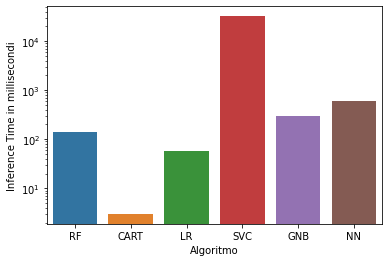

In [20]:
csv = read_csv("InfTimeReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['inf10'])
g.set_yscale("log")
plt.ylabel("Inference Time in millisecondi")
plt.show()

## Memoria Occupata

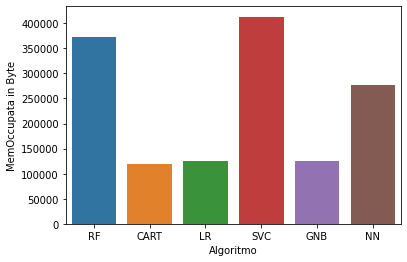

In [21]:
csv = read_csv("MemOccupationReport.csv")
sbs.barplot(x=csv['Algoritmo'], y=csv['Mem10'])
plt.ylabel("MemOccupata in Byte")
plt.show()